<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigureS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# @title Importe libraries and functions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import warnings
from scipy.stats import ttest_rel
import statsmodels.stats.multitest as smm
import matplotlib.patches as patches

def lighten(c, factor=0.7):
    # factor ~0.3–0.4 = lighter; 1.0 = original
    r, g, b = mcolors.to_rgb(c)
    return ((1-factor)*1.0 + factor*r,
            (1-factor)*1.0 + factor*g,
            (1-factor)*1.0 + factor*b)
            
# Function for stars
def p_to_star(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

warnings.filterwarnings("ignore")

Statistical comparison (paired t-tests vs saline with Holm-Bonferroni correction):

0.2 mg/kg  | t = -0.586 | p = 0.5763 | corrected p = 0.5763 | significant: ns
0.3 mg/kg  | t =  1.420 | p = 0.1986 | corrected p = 0.3972 | significant: ns
0.4 mg/kg  | t =  8.333 | p = 7.021e-05 | corrected p = 0.0002106 | significant: ***
0.6 mg/kg  | t =  9.327 | p = 3.381e-05 | corrected p = 0.0001352 | significant: ***


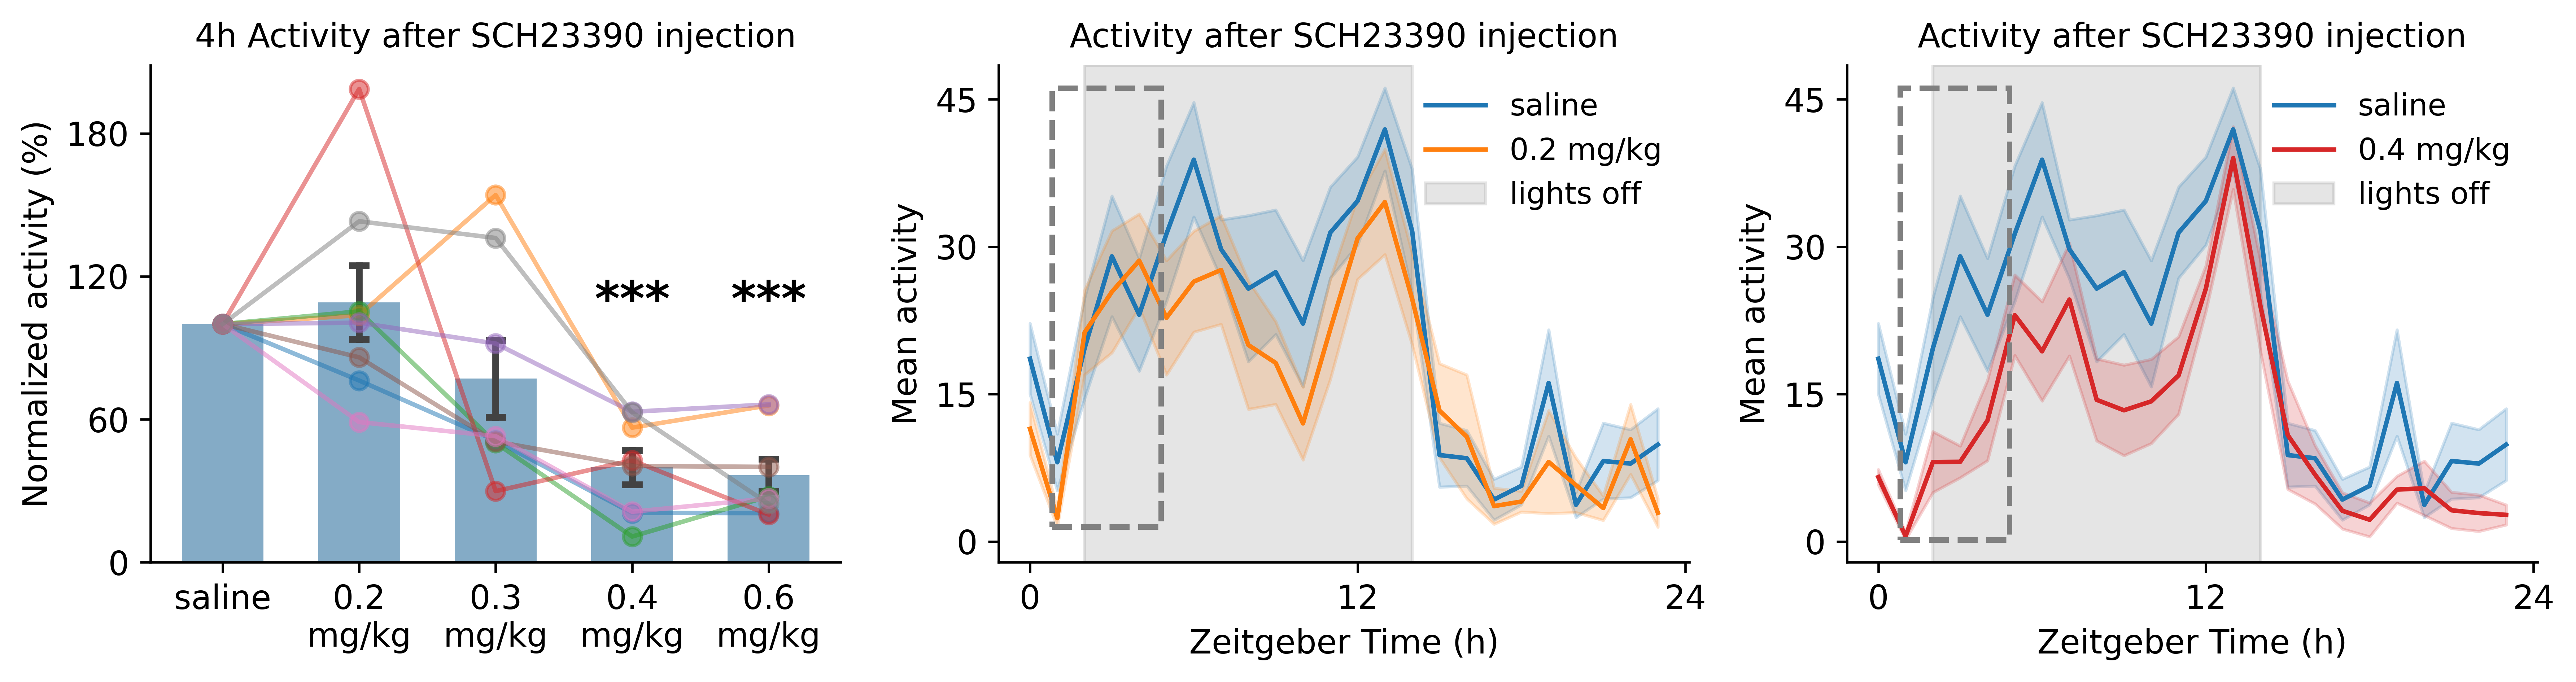

In [2]:
# @title Figure S4A-B
# Load and preprocess data
df1 = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS4a.csv")

conditions = ['0.2 mg/kg', '0.3 mg/kg', '0.4 mg/kg', '0.6 mg/kg']
saline_means = df1[df1['day_label'] == 'saline'].set_index('id')['mean']
saline_vals = df1[df1['day_label'] == 'saline'].set_index('id')['mean_normalized']

# Run paired t-tests
pvals = []
comparisons = []

for condition in conditions:
    drug_vals = df1[df1['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    pvals.append(p)
    comparisons.append((condition, p))

# Holm-Bonferroni correction
reject, pvals_corrected, _, _ = smm.multipletests(pvals, method='holm')

print("Statistical comparison (paired t-tests vs saline with Holm-Bonferroni correction):\n")
for (condition, raw_p), corrected_p, rej in zip(comparisons, pvals_corrected, reject):
    drug_vals = df1[df1['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    star = p_to_star(corrected_p)
    print(f"{condition:<10} | t = {tstat:>6.3f} | p = {raw_p:.4g} | corrected p = {corrected_p:.4g} | significant: {star or 'ns'}")

fig, axes = plt.subplots(1, 3, figsize=(12, 3.25), dpi=600)

# Figure 1: Barplot with line plots
ax1 = axes[0]
sns.barplot(
    data=df1, 
    x='day_label',
    y='mean_normalized',
    errorbar='se',
    alpha=0.6,
    capsize=0.1,
    width=0.6,
    ax=ax1
)

for individual_id in df1['id'].unique():
    individual_data = df1[df1['id'] == individual_id]
    ax1.plot(
        individual_data['day_label'],
        individual_data['mean_normalized'],
        marker='o',
        linestyle='-',
        label=individual_id,
        zorder=4,
        alpha=0.5
    )

ax1.set_title('4h Activity after SCH23390 injection', fontsize=11)
ax1.set_ylabel('Normalized activity (%)', fontsize=11)
ax1.set_xlabel('', fontsize=11)
custom_labels = ['saline', '0.2\nmg/kg', '0.3\nmg/kg', '0.4\nmg/kg', '0.6\nmg/kg']
ax1.set_xticks(range(len(custom_labels)))
ax1.set_xticklabels(custom_labels, fontsize=11)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=4))
ax1.tick_params(axis='y', labelsize=11)
ax1.legend([], frameon=False)

y_offset = df1['mean_normalized'].max() * .5
for i, (condition, p_corr) in enumerate(zip(conditions, pvals_corrected), start=1):  # start=1 to match bar positions
    star = p_to_star(p_corr)
    if star:
        ax1.text(
            i, y_offset, star,
            ha='center',
            va='bottom',
            fontsize=16,
            color='black',
            fontweight='bold'
        )

sns.despine(ax=ax1, top=True, right=True)

df2 = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS4b.csv")

# ---- circadian panel (saline vs 0.2 mg/kg only) ----
subset_labels = ['saline', '0.2 mg/kg']
df_subset = df2[df2['day_label'].isin(subset_labels)]

ax2 = axes[1]
sns.lineplot(
    data=df_subset,  
    x="zthour",
    y="mean",
    hue="day_label",
    errorbar="se",
    ax=ax2
)

x_ticks = [0, 12, 24]
x_tick_labels = ['0', '12', '24']
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=11)
ax2.set_ylabel("Mean activity", fontsize=11)
ax2.set_xlabel('Zeitgeber Time (h)', fontsize=11)
ax2.tick_params(axis='y',labelsize = 11)
ax2.yaxis.set_major_locator(MaxNLocator(4))
ax2.axvspan(2, 14, color='gray', alpha=.2, zorder=0, label='lights off')
ax2.legend(loc='upper right', frameon=False, fontsize=10)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Activity after SCH23390 injection', fontsize=11)

# Compute mean and SEM for each group
summary = df_subset.groupby(['day_label', 'zthour'])['mean'].agg(['mean', 'sem']).reset_index()

# Compute global ymin and ymax across the whole time range
summary['lower'] = summary['mean'] - summary['sem']
summary['upper'] = summary['mean'] + summary['sem']
ymin = summary['lower'].min()
ymax = summary['upper'].max()

# Create and add the dashed rectangle from ZT1 to ZT5
box = patches.Rectangle(
    (0.8, ymin),           # Lower-left corner: ZT1
    4,                   # Width from ZT1 to ZT5 (ZT5 − ZT1 = 4)
    ymax - ymin,         # Height from global lower to upper bound
    linewidth=1.8,
    edgecolor='gray',
    facecolor='none',
    linestyle='--',
    zorder=5
)
ax2.add_patch(box)

# ---- circadian panel (saline vs 0.4 mg/kg only) ----
ax3 = axes[2]

# Subset data to only saline and 0.4 mg/kg
subset_labels = ['saline', '0.4 mg/kg']
df_subset = df2[df2['day_label'].isin(subset_labels)]
custom_palette = {
    'saline': 'tab:blue',     # default first color
    '0.4 mg/kg': 'tab:red'  # default third color
}

sns.lineplot(
    data=df_subset,
    x="zthour",
    y="mean",
    hue="day_label",
    errorbar="se",
    ax=ax3,
    palette=custom_palette
)

# Axis formatting (match ax2 for consistency)
x_ticks = [0, 12, 24]
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(['0', '12', '24'], fontsize=11)
ax3.set_ylabel("Mean activity", fontsize=11)
ax3.set_xlabel("Zeitgeber Time (h)", fontsize=11)
ax3.tick_params(axis='y', labelsize=11)
ax3.yaxis.set_major_locator(MaxNLocator(4))
ax3.axvspan(2, 14, color='gray', alpha=.2, zorder=0, label='lights off')
ax3.legend(loc='upper right', frameon=False, fontsize=10)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Activity after SCH23390 injection', fontsize=11)

# Add dashed rectangle highlighting ZT1–ZT5 window
summary_sub = df_subset.groupby(['day_label', 'zthour'])['mean'].agg(['mean', 'sem']).reset_index()
summary_sub['lower'] = summary_sub['mean'] - summary_sub['sem']
summary_sub['upper'] = summary_sub['mean'] + summary_sub['sem']
ymin = summary_sub['lower'].min()
ymax = summary_sub['upper'].max()

box = patches.Rectangle(
    (0.8, ymin),  # Lower-left corner at ~ZT1
    4,            # Width (ZT5 − ZT1 = 4)
    ymax - ymin,  # Height
    linewidth=1.8,
    edgecolor='gray',
    facecolor='none',
    linestyle='--',
    zorder=5
)
ax3.add_patch(box)
ymin = min(ax2.get_ylim()[0], ax3.get_ylim()[0])
ymax = max(ax2.get_ylim()[1], ax3.get_ylim()[1])
ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

# Adjust layout
plt.tight_layout()
plt.show()

Statistical comparison (paired t-tests vs saline with Holm-Bonferroni correction):

0.1 mg/kg  | t =  0.878 | p = 0.4092 | corrected p = 0.4092 | significant: ns
0.2 mg/kg  | t =  7.445 | p = 0.0001439 | corrected p = 0.0005754 | significant: ***
0.4 mg/kg  | t =  4.788 | p = 0.001993 | corrected p = 0.005187 | significant: **
0.6 mg/kg  | t =  4.912 | p = 0.001729 | corrected p = 0.005187 | significant: **


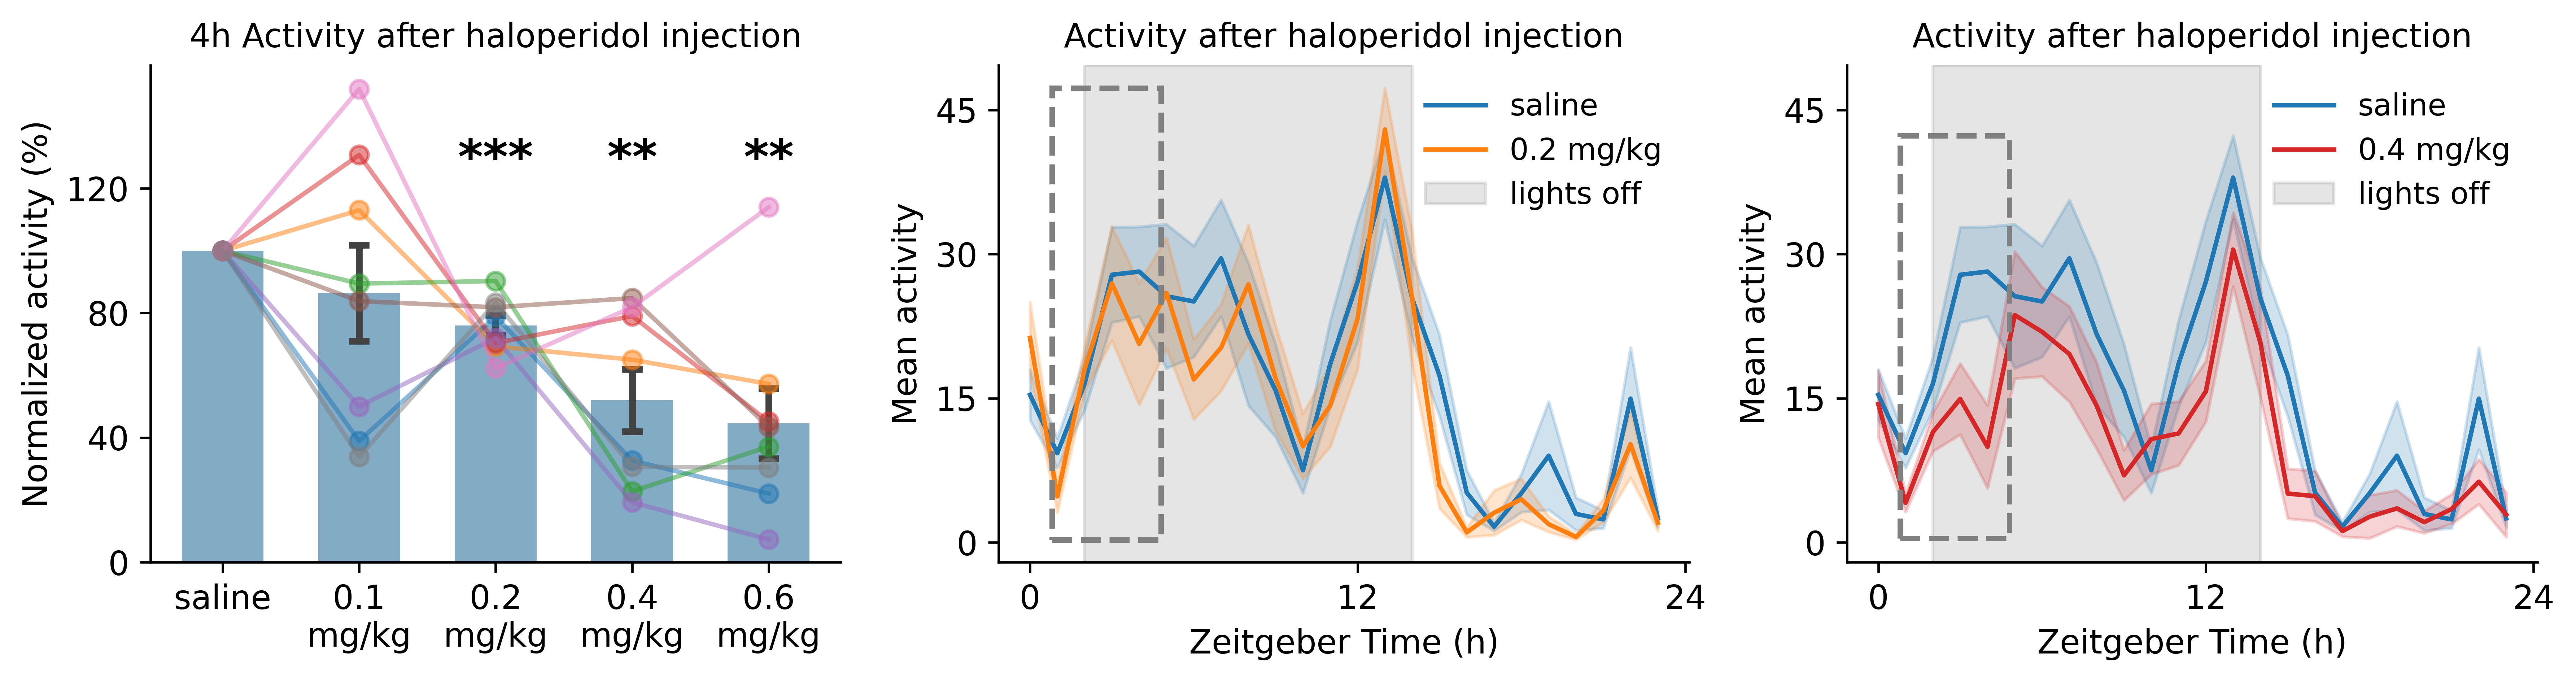

In [ ]:
# @title Figure S4C-D
# Load and preprocess data
df1 = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS4c.csv")
# Run paired t-tests
pvals = []
comparisons = []
conditions = ['0.1 mg/kg', '0.2 mg/kg', '0.4 mg/kg', '0.6 mg/kg']
saline_means = df1[df1['day_label'] == 'saline'].set_index('id')['mean']
saline_vals = df1[df1['day_label'] == 'saline'].set_index('id')['mean_normalized']

for condition in conditions:
    drug_vals = df1[df1['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    pvals.append(p)
    comparisons.append((condition, p))

# Holm-Bonferroni correction
reject, pvals_corrected, _, _ = smm.multipletests(pvals, method='holm')

print("Statistical comparison (paired t-tests vs saline with Holm-Bonferroni correction):\n")
for (condition, raw_p), corrected_p, rej in zip(comparisons, pvals_corrected, reject):
    drug_vals = df1[df1['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    star = p_to_star(corrected_p)
    print(f"{condition:<10} | t = {tstat:>6.3f} | p = {raw_p:.4g} | corrected p = {corrected_p:.4g} | significant: {star or 'ns'}")

fig, axes = plt.subplots(1, 3, figsize=(12, 3.25), dpi=600)

# Figure 1: Barplot with line plots
ax1 = axes[0]
sns.barplot(
    data=df1,
    x='day_label',
    y='mean_normalized',
    errorbar='se',
    alpha=0.6,
    capsize=0.1,
    width=0.6,
    ax=ax1
)

for individual_id in df1['id'].unique():
    individual_data = df1[df1['id'] == individual_id]
    ax1.plot(
        individual_data['day_label'],
        individual_data['mean_normalized'],
        marker='o',
        linestyle='-',
        label=individual_id,
        zorder=4,
        alpha=0.5
    )

ax1.set_title('4h Activity after haloperidol injection', fontsize=11)
ax1.set_ylabel('Normalized activity (%)', fontsize=11)
ax1.set_xlabel('', fontsize=11)
custom_labels = ['saline', '0.1\nmg/kg', '0.2\nmg/kg', '0.4\nmg/kg', '0.6\nmg/kg']
ax1.set_xticks(range(len(custom_labels)))
ax1.set_xticklabels(custom_labels, fontsize=11)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=4))
ax1.tick_params(axis='y', labelsize=11)
ax1.legend([], frameon=False)

y_offset = df1['mean_normalized'].max() * .8
for i, (condition, p_corr) in enumerate(zip(conditions, pvals_corrected), start=1):  # start=1 to match bar positions
    star = p_to_star(p_corr)
    if star:
        ax1.text(
            i, y_offset, star,
            ha='center',
            va='bottom',
            fontsize=16,
            color='black',
            fontweight='bold'
        )

sns.despine(ax=ax1, top=True, right=True)

df2 = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS4d.csv")

# ---- circadian panel (saline vs 0.2 mg/kg only) ----
subset_labels = ['saline', '0.2 mg/kg']
df_subset = df2[df2['day_label'].isin(subset_labels)]

ax2 = axes[1]
sns.lineplot(
    data=df_subset,  
    x="zthour",
    y="mean",
    hue="day_label",
    errorbar="se",
    ax=ax2
)

x_ticks = [0, 12, 24]
x_tick_labels = ['0', '12', '24']
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=11)
ax2.set_ylabel("Mean activity", fontsize=11)
ax2.set_xlabel('Zeitgeber Time (h)', fontsize=11)
ax2.tick_params(axis='y',labelsize = 11)
ax2.yaxis.set_major_locator(MaxNLocator(4))
ax2.axvspan(2, 14, color='gray', alpha=.2, zorder=0, label='lights off')
ax2.legend(loc='upper right', frameon=False, fontsize=10)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Activity after haloperidol injection', fontsize=11)

# Compute mean and SEM for each group
summary = df_subset.groupby(['day_label', 'zthour'])['mean'].agg(['mean', 'sem']).reset_index()

# Compute global ymin and ymax across the whole time range
summary['lower'] = summary['mean'] - summary['sem']
summary['upper'] = summary['mean'] + summary['sem']
ymin = summary['lower'].min()
ymax = summary['upper'].max()

# Create and add the dashed rectangle from ZT1 to ZT5
box = patches.Rectangle(
    (0.8, ymin),           # Lower-left corner: ZT1
    4,                   # Width from ZT1 to ZT5 (ZT5 − ZT1 = 4)
    ymax - ymin,         # Height from global lower to upper bound
    linewidth=1.8,
    edgecolor='gray',
    facecolor='none',
    linestyle='--',
    zorder=5
)
ax2.add_patch(box)

# ---- circadian panel (saline vs 0.4 mg/kg only) ----
ax3 = axes[2]

# Subset data to only saline and 0.4 mg/kg
subset_labels = ['saline', '0.4 mg/kg']
df_subset = df2[df2['day_label'].isin(subset_labels)]
custom_palette = {
    'saline': 'tab:blue',     # default first color
    '0.4 mg/kg': 'tab:red'  # default third color
}

sns.lineplot(
    data=df_subset,
    x="zthour",
    y="mean",
    hue="day_label",
    errorbar="se",
    ax=ax3,
    palette=custom_palette
)

# Axis formatting (match ax2 for consistency)
x_ticks = [0, 12, 24]
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(['0', '12', '24'], fontsize=11)
ax3.set_ylabel("Mean activity", fontsize=11)
ax3.set_xlabel("Zeitgeber Time (h)", fontsize=11)
ax3.tick_params(axis='y', labelsize=11)
ax3.yaxis.set_major_locator(MaxNLocator(4))
ax3.axvspan(2, 14, color='gray', alpha=.2, zorder=0, label='lights off')
ax3.legend(loc='upper right', frameon=False, fontsize=10)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Activity after haloperidol injection', fontsize=11)

# Add dashed rectangle highlighting ZT1–ZT5 window
summary_sub = df_subset.groupby(['day_label', 'zthour'])['mean'].agg(['mean', 'sem']).reset_index()
summary_sub['lower'] = summary_sub['mean'] - summary_sub['sem']
summary_sub['upper'] = summary_sub['mean'] + summary_sub['sem']
ymin = summary_sub['lower'].min()
ymax = summary_sub['upper'].max()

box = patches.Rectangle(
    (0.8, ymin),  # Lower-left corner at ~ZT1
    4,            # Width (ZT5 − ZT1 = 4)
    ymax - ymin,  # Height
    linewidth=1.8,
    edgecolor='gray',
    facecolor='none',
    linestyle='--',
    zorder=5
)
ax3.add_patch(box)
ymin = min(ax2.get_ylim()[0], ax3.get_ylim()[0])
ymax = max(ax2.get_ylim()[1], ax3.get_ylim()[1])
ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

# Adjust layout
plt.tight_layout()
plt.show()

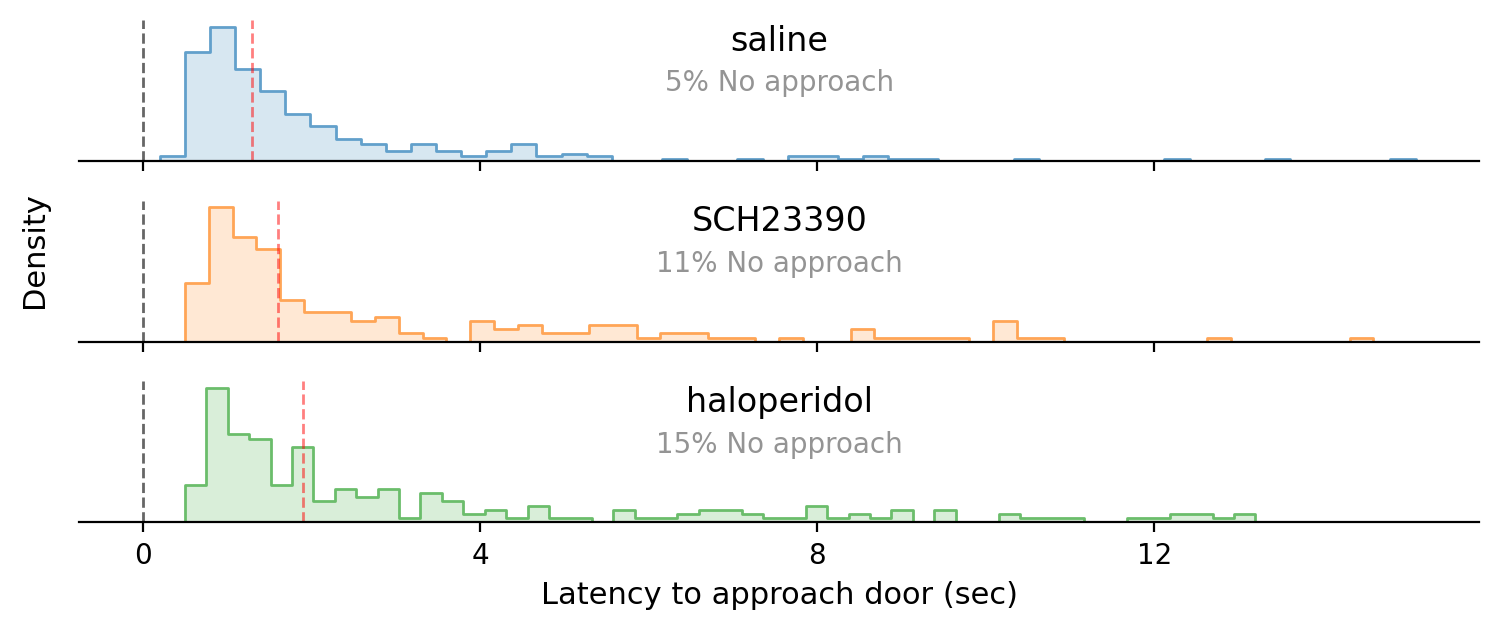

In [6]:
# @title Figure S4E
# Load and preprocess data

df = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS4e.csv")

# --- your colors ---
treatment_order = ['saline 0.3 mg/kg', 'SCH23390 0.3 mg/kg', 'haloperidol 0.3 mg/kg']
treatment_col = 'treatment'
default_palette = sns.color_palette()
treatment_color_map = {
    'saline 0.3 mg/kg':     default_palette[0],  # blue
    'SCH23390 0.3 mg/kg':   default_palette[1],  # orange
    'haloperidol 0.3 mg/kg':default_palette[2],  # green
}

sub = df[df['approach_latency2'].notna()].copy()
present = [t for t in treatment_order if t in sub[treatment_col].unique()]
if not present:
    present = list(pd.unique(sub[treatment_col]))
sub[treatment_col] = pd.Categorical(sub[treatment_col], categories=present, ordered=True)

# --- HISTPLOT VERSION ---

n_trt = len(present)
fig, axes = plt.subplots(
    n_trt, 1,
    figsize=(7.3, 3.25),  # keep size
    dpi=200,
    sharex=True
)

# make sure axes is iterable
if n_trt == 1:
    axes = [axes]

for i, trt in enumerate(present):
    ax_i = axes[i]
    row = sub[sub[treatment_col] == trt]

    # base color for this treatment
    base = treatment_color_map.get(trt, default_palette[0])
    pal = {
        'Seeking': lighten(base),          # lighter version
        'No approaching': lighten(base, 0.35)
    }

    # histogram of approach_latency2 for this treatment
    sns.histplot(
        data=row,
        x='approach_latency2',
        hue='approach_category',
        hue_order=['Seeking', 'No approaching'],
        bins=50,
        stat='density',
        common_norm=False,
        multiple='layer',   # both distributions visible
        element='step',     # nice outline
        fill=True,
        palette=pal,
        ax=ax_i
    )

    # median line
    median_val = row['approach_latency2'].median()
    ax_i.axvline(
        median_val,
        color='red',
        linestyle='--',
        linewidth=1.0,
        alpha=0.5
    )

    # vertical line at 0 (same as before)
    ax_i.axvline(x=0, color='black', linestyle='--', linewidth=1.0, alpha=0.6)

    # remove legend for each panel
    ax_i.legend_.remove() if ax_i.get_legend() is not None else None

    # treatment label inside the axis (like your y-axis text)
    ax_i.text(
        0.5, 0.85,
        trt.split(" ")[0],
        transform=ax_i.transAxes,
        ha='center', va='center',
        fontsize=12, color='black'
    )

    # percentage annotation (using same percs table as before)
    # Ensure categorical order for the hue
    cats = ['Seeking', 'No approaching']

    # --- percentages: DO NOT drop NaNs here ---
    counts = (df.groupby([treatment_col, 'approach_category'], dropna=False)
                .size()
                .unstack(fill_value=0)
                .reindex(columns=cats, fill_value=0))

    percs = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    seek = float(percs.loc[trt].get('Seeking', 0.0)) * 100.0
    noap = float(percs.loc[trt].get('No approaching', 0.0)) * 100.0

    seek_color = lighten(base, 1)
    noap_color = "#949494"


    # put the percentages toward the center-bottom of the panel
    ax_i.text(
        0.5, 0.55,
        f"{noap:.0f}% No approach",
        transform=ax_i.transAxes,
        ha='center', va='center',
        fontsize=10,
        color=noap_color
    )

    # cosmetics
    sns.despine(ax=ax_i, left=True)
    ax_i.set_ylabel('')
    ax_i.yaxis.set_ticks([])

fig.text(-0.02, 0.6, 'Density', va='center', rotation='vertical', fontsize=11)


# only bottom panel gets an x-label and ticks
for ax_i in axes[:-1]:
    ax_i.set_xlabel('')
axes[-1].set_xlabel('Latency to approach door (sec)', fontsize=11)
axes[-1].xaxis.set_major_locator(MaxNLocator(5, integer=False))

plt.tight_layout()
plt.show()



In [9]:
from scipy.stats import friedmanchisquare, wilcoxon
from pandas.api.types import CategoricalDtype

# If you don't already have holm_bonferroni(), use this:
def holm_bonferroni(pvals):
    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    order = np.argsort(pvals)
    p_sorted = pvals[order]
    adj_sorted = np.maximum.accumulate((m - np.arange(m)) * p_sorted)
    adj_sorted = np.minimum(adj_sorted, 1.0)
    # put back in original order
    p_adj = np.empty_like(adj_sorted)
    p_adj[order] = adj_sorted
    return p_adj

def add_sig_line(ax, x1, x2, y, p_val):
    if   p_val < 1e-4: stars = '****'
    elif p_val < 1e-3: stars = '***'
    elif p_val < 1e-2: stars = '**'
    elif p_val < 5e-2: stars = '*'
    else: return
    ax.plot([x1, x2], [y, y], lw=1.5, c='gray')
    ax.text((x1 + x2) / 2, y*0.97, stars, ha='center', va='bottom', fontsize=15, fontweight='bold')

def run_stats_and_annotate(ax, grouped, treatment_order, x_map, y_max):
    # grouped must have columns: device_number, treatment, value (wide pivot below)
    anova_df = grouped.pivot(index='device_number', columns='treatment', values='value').dropna()
    # Require all treatments present (within-subject design)
    if all(t in anova_df.columns for t in treatment_order):
        stat, p = friedmanchisquare(
            anova_df[treatment_order[0]],
            anova_df[treatment_order[1]],
            anova_df[treatment_order[2]],
        )
        print(f'Friedman test χ²={stat:.3f}, p={p:.3g}')
        i=0
        pairs = [(treatment_order[0], treatment_order[1]),
                 (treatment_order[0], treatment_order[2])]
        results = []
        print(i)
        for a, b in pairs:
            res = wilcoxon(anova_df[a], anova_df[b])
            results.append({'pair': (a, b), 'stat': res.statistic, 'p_raw': res.pvalue})
        i+=1
        p_raws = [r['p_raw'] for r in results]
        p_adj  = holm_bonferroni(p_raws)
        print(i)
        for r, pA in zip(results, p_adj):
            a, b = r['pair']
            print(f"Wilcoxon {a} vs {b}: T={r['stat']:.3f}, pHolm={pA:.3g} (raw={r['p_raw']:.3g})")
        # annotate
        y_offset = 0.06 * y_max
        base_y = 1.02 * y_max
        for (a, b), pA in zip([r['pair'] for r in results], p_adj):
            if pA < 0.05:
                add_sig_line(ax, x_map[a], x_map[b], base_y, pA)
                base_y += 1.5 * y_offset

Friedman test χ²=16.745, p=0.000231
0
1
Wilcoxon saline vs SCH23390: T=15.000, pHolm=0.0327 (raw=0.0327)
Wilcoxon saline vs haloperidol: T=0.000, pHolm=0.000488 (raw=0.000244)


(<Figure size 866x650 with 1 Axes>, <Axes: ylabel='Approach latency (sec)'>)

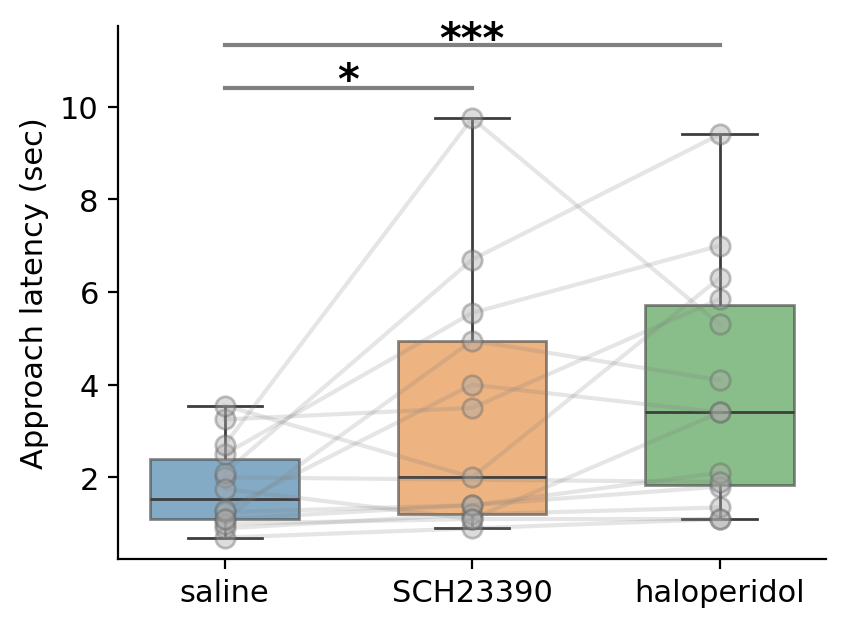

In [14]:
# @title Figure S4F
# Load and preprocess data

df = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS4f.csv")
def plot_per_device_stats(
    df0, col, agg='mean', behavior='Seeking'):
    """
    Plot per-device boxplot, lines, and stats for a given column and aggregation.

    Args:
        df0: DataFrame with columns ['treatment','behavior','device_number', col]
        col: column name to plot (e.g., 'approachtime2')
        agg: 'mean' or 'sum'
        behavior: which behavior to filter (default 'Seeking')
        figsize: tuple (width, height) in inches for the figure size
        dpi: dots-per-inch for the figure
        save_path: if provided, save the figure to this path
        transparent: save with transparent background (when saving)
    """

    # Create figure/axes with requested size
    fig, ax = plt.subplots(figsize=(4.33, 3.25), dpi=200)

    # Color mapping
    default_palette = sns.color_palette()
    treatment_color_map = {
        'saline': default_palette[0],
        'SCH23390': default_palette[1],
        'haloperidol': default_palette[2]
    }
    order = ['saline','SCH23390','haloperidol']

    # Relabel treatments for plotting
    df = df0.copy()
    df["treatment"] = df["treatment"].replace({
        'saline 0.3 mg/kg': 'saline',
        'SCH23390 0.3 mg/kg': 'SCH23390',
        'haloperidol 0.3 mg/kg':'haloperidol'
    })

    # Per-device aggregation for selected behavior
    if agg == 'median':
        m = (df.query(f'behavior=="{behavior}"')
               .groupby(['treatment','behavior','device_number'])[col]
               .median()
               .reset_index())
    elif agg == 'sum':
        m = (df.query(f'behavior=="{behavior}"')
               .groupby(['treatment','behavior','device_number'])[col]
               .sum()
               .reset_index())
    else:
        raise ValueError("agg must be 'median' or 'sum'")

    m['treatment'] = m['treatment'].astype(CategoricalDtype(categories=order, ordered=True))

    # Boxplot (behind)
    sns.boxplot(
        data=m, x='treatment', y=col, ax=ax,
        boxprops=dict(alpha=0.6), width=0.6,
        order=order, palette=treatment_color_map, showfliers=False, zorder=1
    )

    # Per-device connecting lines (all grey)
    sns.lineplot(
        data=m, x='treatment', y=col, ax=ax,
        units='device_number', estimator=None,
        dashes=False, markers=False, legend=False, zorder=3, color='grey', alpha=0.2
    )

    # Strip plot
    sns.stripplot(data=m, x='treatment', y=col, dodge=False, jitter=False, size=7, order=['saline','SCH23390','haloperidol'],
                    marker='o', alpha=0.4, color='darkgray', linewidth=1, ax=ax)

    # Compute y_max before annotations and give headroom
    y_data_max = np.nanmax(m[col].to_numpy())
    y_axis_max = ax.get_ylim()[1]
    y_max = max(y_data_max, y_axis_max)
    ax.set_ylim(top=y_max * 1.15)  # headroom for stars

    # Prepare data for stats runner: columns device_number, treatment, value
    grouped = m.rename(columns={col: 'value'})[['device_number','treatment','value']]

    # Map category -> x position used by seaborn (0..n-1 in 'order')
    x_map = {cat: i for i, cat in enumerate(order)}

    # Run stats and annotate (assumes you have this function defined)
    run_stats_and_annotate(ax, grouped, order, x_map, y_max)

    ax.set_xlabel('')
    ax.set_ylabel("Approach latency (sec)", fontsize=11)
    ax.tick_params('both', labelsize=11)
    sns.despine()
    fig.tight_layout()
    fig.show()

    return fig, ax

plot_per_device_stats(df, 'approach_latency2', agg='median', behavior='Seeking')